# Python Fever Final Project
* Danish Ali
* Adam Burstyn
* Trevor Flanagan
* Ian Haas
* Hope Miller

This notebook contains the code used to explore movie data to make recommendations to Computing Vision, a new movie studio. We are looking to make recommendations for the best type of film to produce based on recent box office success of other films.
***
## Table of Contents:
* [Background](#Background)
    * [Domestic vs. International Revenue](#Domestic_vs_International_Revenue)
* [Explore gross revenues](#Explore_gross_revenues)
    * [Gross Revenues Visualizations](#gross_revenues_vis)
    * [Explore statistical significance between the genres](#gross_sig)
* [Recommendation 1](#rec1)
* [Explore Net Revenue Produced](#explore_net_rev)
* [Recommendation 2](#rec2)
* [Explore Popularity](#explore_popularity)
    * [Load in and prep additional data](#load_data)
    * [Convert genre_ids to names](#genre_dict) 
    * [Grouping popularity data by genre for visualization](#popularity_vis)
    * [Test for statistical significance between highest popularity groups](#popularity_sig)
    * [Explore TMDB Vote Averages](#votes)
* [Recommendation 3](#rec3)
* [Conclusion](#conclusion)

## Background <a class="anchor" id="Background"></a>
In todays digital world tags or hash-tags are heavily used in online social media marketing. We feel that looking into the most successful movies based on genre tags applied to the film will be a good indicator of success in todays digital landscape.

The areas of gross revenue, net revenue and popularity were selected based on the following:
* Having the highest gross revenue will give you the biggest reach at the box office.
* Having the highest net profit will result in the most money made.
* Having the highest popularity will result in the biggest online presence, helping promote the movie/studio.

We will looking to make recomendations based on gross revenues by genre tags, net revenues by genre tags, and movie popularity by genre tags.

We are provided domestic as well as international reveneus. We will need to decide which one to use for revenue based analysis.

We will use mean revenue for comaprison because we want the high outlier values to influence the numbers as creating an outlier (high grossing) film is desireable.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from helper_functions import *
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# upload clean data from helper function
# code can be seen in helper_functions.py
df = get_clean_df()
df.head()

,movie_id,averagerating,numvotes,primary_title,original_title,year,runtime_minutes,genres,ordering,title,...,id,release_date,production_budget,domestic_gross_movie_budgets,worldwide_gross_movie_budgets,studio,domestic_gross_movie_gross,foreign_gross_movie_gross,clean_domestic_gross,clean_worldwide_gross
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",20,thelegendofhercules,...,42.0,"Jan 10, 2014",70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,baggageclaim,...,38.0,"Sep 27, 2013",8500000.0,21569509.0,22885836.0,NaN,NaN,NaN,21569509.0,22885836.0
2,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",14,moneyball,...,15.0,"Sep 23, 2011",50000000.0,75605492.0,111300835.0,NaN,NaN,NaN,75605492.0,111300835.0
3,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",4,hereafter,...,61.0,"Oct 15, 2010",50000000.0,32746941.0,108660270.0,NaN,NaN,NaN,32746941.0,108660270.0
4,tt1232829,7.2,477771,21 Jump Street,21 Jump Street,2012,109.0,"Action,Comedy,Crime",26,21jumpstreet,...,44.0,"Mar 16, 2012",42000000.0,138447667.0,202812429.0,NaN,NaN,NaN,138447667.0,202812429.0


### Domestic vs. International Revenue <a class="anchor" id="Domestic_vs_International_Revenue"></a>
We will examine a scatter plot and fit a line to the data points to see how well they relate to each other. The r^2 value will show how closely realted the variables are. The closer to 1 the r^2 value is, the more closely related they are. The closer to 0 the r^2 value is, the less related they are.

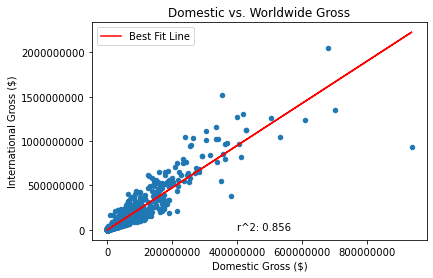

In [3]:
# investigate if there is there a relationship between domestic gross and foreign gross
ax = df.plot(x="clean_domestic_gross", y="clean_worldwide_gross", kind="scatter",
                           title="Domestic vs. Worldwide Gross", xlabel="Domestic Gross ($)", ylabel="International Gross ($)")

# remove scientific notation
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

# plot regression line
m = stats.linregress(df["clean_domestic_gross"].to_list(), y=df["clean_worldwide_gross"].to_list())
t = [m.slope * i + m.intercept for i in df["clean_domestic_gross"]]

df["regression"] = t

df.plot.line(x="clean_domestic_gross", y="regression", color='r', ax=ax, 
             xlabel="Domestic Gross ($)", ylabel="International Gross ($)", label="Best Fit Line")
ax.annotate(f"r^2: {round(m.rvalue**2, 3)}", xy=(400000000, 1));

# save the image
plt.savefig("./Images/gross_scatter_plot.png", bbox_inches='tight')

The scatter plot and r^2 value close to 1 (.856) shows that there is a strong correlation between international and domestic gross revenues. Therefore we can use either one to make recomendations. We will use domestic reveneus for this analysis since it is a new US based company and their scope may not have international reach yet.

## Explore gross revenues <a class="anchor" id="Explore_gross_revenues"></a>

In [4]:
# look at column names
df.columns

Index(['movie_id', 'averagerating', 'numvotes', 'primary_title',
       'original_title', 'year', 'runtime_minutes', 'genres', 'ordering',
       'title', 'region', 'language', 'types', 'attributes',
       'is_original_title', 'id', 'release_date', 'production_budget',
       'domestic_gross_movie_budgets', 'worldwide_gross_movie_budgets',
       'studio', 'domestic_gross_movie_gross', 'foreign_gross_movie_gross',
       'clean_domestic_gross', 'clean_worldwide_gross', 'regression'],
      dtype='object')

In [5]:
# Split and explode the genres column to sepperate movies that are listed with more than one genre.
df['genres'] = df['genres'].str.split(',')
df = df.explode('genres').reset_index(drop=True)
df.head()

,movie_id,averagerating,numvotes,primary_title,original_title,year,runtime_minutes,genres,ordering,title,...,release_date,production_budget,domestic_gross_movie_budgets,worldwide_gross_movie_budgets,studio,domestic_gross_movie_gross,foreign_gross_movie_gross,clean_domestic_gross,clean_worldwide_gross,regression
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,Action,20,thelegendofhercules,...,"Jan 10, 2014",70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0,4.216818e+07
1,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,Adventure,20,thelegendofhercules,...,"Jan 10, 2014",70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0,4.216818e+07
2,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,Fantasy,20,thelegendofhercules,...,"Jan 10, 2014",70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0,4.216818e+07
3,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,baggageclaim,...,"Sep 27, 2013",8500000.0,21569509.0,22885836.0,NaN,NaN,NaN,21569509.0,22885836.0,4.864664e+07
4,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,Biography,14,moneyball,...,"Sep 23, 2011",50000000.0,75605492.0,111300835.0,NaN,NaN,NaN,75605492.0,111300835.0,1.773029e+08


In [6]:
# look at the genres
df["genres"].unique()

array(['Action', 'Adventure', 'Fantasy', 'Comedy', 'Biography', 'Drama',
       'Sport', 'Romance', 'Crime', 'Thriller', 'Sci-Fi', 'Mystery',
       'Horror', 'Documentary', 'War', 'Family', 'Animation', 'History',
       'Music', 'Musical', 'Western', None], dtype=object)

There is a category for music and musicals. We will combine these.

In [7]:
# combine music and musicals
df["genres"] = df["genres"].replace("Music", "Musical")

In [8]:
# drop dulicates incase there are movies that are tagged as music and musical
df = df.drop_duplicates()

In [9]:
# keep only movies in the past 10 years
df = df[df["year"]>2000]

In [10]:
# Describe the gross income column that will be used for analysis.
df['clean_domestic_gross'].describe()

count    3.393000e+03
mean     5.015626e+07
std      8.252312e+07
min      0.000000e+00
25%      1.400000e+06
50%      2.159644e+07
75%      6.143353e+07
max      9.367000e+08
Name: clean_domestic_gross, dtype: float64

In [11]:
# check the number of records
print(f"There are {len(df)} records in the dataset.")

There are 3393 records in the dataset.


### Gross Revenues Visualizations <a class="anchor" id="gross_revenues_vis"></a>

In [12]:
# groupby meangross domestic revenue
rev_genres = df.groupby('genres').mean()[['clean_domestic_gross']].sort_values('clean_domestic_gross', ascending = False)
rev_genres

,clean_domestic_gross
genres,
Animation,1.174243e+08
Adventure,1.076802e+08
Sci-Fi,1.019693e+08
Fantasy,8.079282e+07
Family,7.481686e+07
Action,7.158211e+07
Western,5.392671e+07
Comedy,5.040749e+07
Musical,4.762251e+07


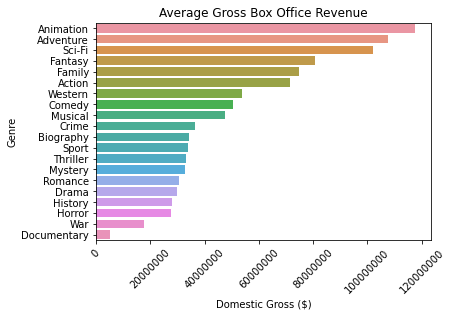

In [13]:
# visualize revenue by genre
labels = rev_genres.index
data = rev_genres['clean_domestic_gross']

f, ax = plt.subplots()

ax = sns.barplot(y=labels, x=data, ax=ax)
plt.title('Average Gross Box Office Revenue')
plt.xlabel("Domestic Gross ($)")
plt.ylabel("Genre")

ax.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45);

# save the image
plt.savefig("./Images/top_gross.png", bbox_inches='tight')

The graph above shows the top 3 genres as Animation, Adventure, and Sci-Fi

### Explore statistical significance between the genres <a class="anchor" id="gross_sig"></a>
We will determine if the observed difference between the top genre tags have a meaningful difference by using a statistical measure known as a t-test. The t-test is used to determine if there is a meaningful difference between the average of two data sets. A siginicant difference is determined by a preset confidence percentage. For this analysis we will use a commonly accepted confidence interval of 95%. In order to meet the 95% confidence metric, we will be looking for the results of the t-test to yeild a p value smaller than .05.
* Although the t-test traditionally assumes the two sets of data follow a normal bell curve, it is robust enough to handle data that do not perfectly meet this criteria.

In [14]:
# seperate genres for testing
animations = df[df['genres']=="Animation"]
adventures = df[df['genres']=="Adventure"]
scifi = df[df['genres']=="Sci-Fi"]
fantasy = df[df['genres']=="Fantasy"]

In [15]:
# check for distribution normality
stats.normaltest(animations["clean_domestic_gross"]), stats.normaltest(adventures['clean_domestic_gross']), stats.normaltest(scifi['clean_domestic_gross']), stats.normaltest(fantasy['clean_domestic_gross'])

(NormaltestResult(statistic=33.85502457431332, pvalue=4.4511765602593714e-08),
 NormaltestResult(statistic=167.54947919203656, pvalue=4.140882149636819e-37),
 NormaltestResult(statistic=59.43232512082682, pvalue=1.2428953885262208e-13),
 NormaltestResult(statistic=106.47225933662679, pvalue=7.583027782835109e-24))

Although the data sets are not perfectly normal, the t-test is robust enough to be applied and we will use this for recommendations.

In [16]:
# conduct t-test to determine if there is a significant difference between the genre tags
# alpha .05
print("Animation-Adventure t-test: ", stats.ttest_ind(animations['clean_domestic_gross'], adventures['clean_domestic_gross'], alternative="greater"))
print("Animation-Sci-Fi t-test: ", stats.ttest_ind(animations['clean_domestic_gross'], scifi['clean_domestic_gross'], alternative="greater"))
print("Animation-Fantasy t-test: ", stats.ttest_ind(animations['clean_domestic_gross'], fantasy['clean_domestic_gross'], alternative="greater"))

Animation-Adventure t-test:  Ttest_indResult(statistic=0.6262140995004922, pvalue=0.2657896149119323)
Animation-Sci-Fi t-test:  Ttest_indResult(statistic=0.7881058573166304, pvalue=0.2158760143168671)
Animation-Fantasy t-test:  Ttest_indResult(statistic=2.0146005277487413, pvalue=0.02270123515244974)


The T-tests show that there is no statistical significant difference between Animations and Adventures and Animations and Sci-Fi. However there is a siginificant difference between Animations and Fantasy, therefore we will use this as a cuttoff point for genre recommendations based on gross revenues.

# Recommendation 1: If the goal is to maximize gross profit, then we recommend producing a movie with the genre tags of Animation, Adventure, or Sci-Fi. <a class="anchor" id="rec1"></a>

## Explore Net Revenue Produced <a class="anchor" id="explore_net_rev"></a>

In [17]:
# calculate net revenue (gross - budget)
df['profit'] = df['clean_domestic_gross'] - df['production_budget']
df.head()

,movie_id,averagerating,numvotes,primary_title,original_title,year,runtime_minutes,genres,ordering,title,...,production_budget,domestic_gross_movie_budgets,worldwide_gross_movie_budgets,studio,domestic_gross_movie_gross,foreign_gross_movie_gross,clean_domestic_gross,clean_worldwide_gross,regression,profit
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,Action,20,thelegendofhercules,...,70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0,4.216818e+07,-51151462.0
1,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,Adventure,20,thelegendofhercules,...,70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0,4.216818e+07,-51151462.0
2,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,Fantasy,20,thelegendofhercules,...,70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0,4.216818e+07,-51151462.0
3,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,baggageclaim,...,8500000.0,21569509.0,22885836.0,NaN,NaN,NaN,21569509.0,22885836.0,4.864664e+07,13069509.0
4,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,Biography,14,moneyball,...,50000000.0,75605492.0,111300835.0,NaN,NaN,NaN,75605492.0,111300835.0,1.773029e+08,25605492.0


In [18]:
# generate mean net profit by genre tag
net = df.groupby('genres').mean()[['profit']].sort_values('profit', ascending = False)
net

,profit
genres,
Animation,3.813516e+07
Musical,3.042948e+07
Comedy,2.105664e+07
Biography,1.923596e+07
Sci-Fi,1.629237e+07
Romance,1.591875e+07
Family,1.518648e+07
Adventure,1.406306e+07
Sport,1.326948e+07


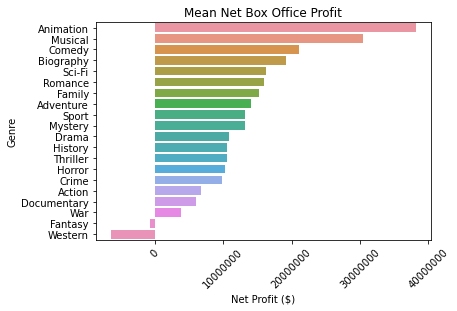

In [19]:
# visualize revenue by genre
labels = net.index
data = net['profit']

f, ax = plt.subplots()
sns.barplot(y=labels, x=data, ax=ax)
plt.title('Mean Net Box Office Profit')
plt.xlabel("Net Profit ($)")
plt.ylabel("Genre")

ax.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45);

# save the image
plt.savefig("./Images/top_net.png", bbox_inches='tight')

The graph above shows that Animation, Musical, and Comedy are the top 3 mean net revenue producing genre tags. Animation and Muscal may possibly be high because they may not include high costing actors. Futher exploration is needed to determine this assumption.

# Recommendation 2: If the goal is to maximize net profit, then we recommend producing a movie with the genre tags of Animation. <a class="anchor" id="rec2"></a>

## Explore Popularity <a class="anchor" id="explore_popularity"></a>

### Load in and prep additional data <a class="anchor" id="load_data"></a>

In [20]:
# load TMDB data
movies = pd.read_csv("./Data/tmdb.movies.csv")
movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [21]:
# make sure there is only one entry per movie
print(len(movies), movies["id"].nunique())

26517 25497


There are some duplicate movie id entries

In [22]:
# keep only original entries
movies = movies.drop_duplicates(subset=["id"])

In [23]:
# look for null values
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25497 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         25497 non-null  int64  
 1   genre_ids          25497 non-null  object 
 2   id                 25497 non-null  int64  
 3   original_language  25497 non-null  object 
 4   original_title     25497 non-null  object 
 5   popularity         25497 non-null  float64
 6   release_date       25497 non-null  object 
 7   title              25497 non-null  object 
 8   vote_average       25497 non-null  float64
 9   vote_count         25497 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.1+ MB


There are no missing entries in this data set

In [24]:
# look at special case of "null" value
movies[movies["title"]=="Baby Dolls Behind Bars"]

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
5698,5698,[],134451,en,Baby Dolls Behind Bars,4.432,2012-06-01,Baby Dolls Behind Bars,4.9,4


In [25]:
# remove missing values
movies = movies[(movies["genre_ids"]!="[]") & (movies["genre_ids"]!="")]

Some entries have blank spaces for genres

In [26]:
# see format of genre ids for cleaning
movies["genre_ids"].value_counts()

[99]                    3565
[18]                    2119
[35]                    1622
[27]                    1125
[53]                     466
                        ... 
[28, 16, 10770]            1
[12, 14, 10749, 878]       1
[14, 35, 878, 10751]       1
[12, 10749, 18]            1
[10751, 12, 28]            1
Name: genre_ids, Length: 2476, dtype: int64

There are brackets and spaces in the strings that will need to be removed so the numbers can be mapped to actual genre tags. We will also need to expand each genre to its own row for analysis.

In [27]:
# get rid of [] in genre ids
movies["genre_ids"] = movies["genre_ids"].str.replace('[', '')
movies["genre_ids"] = movies["genre_ids"].str.replace(']', '')
movies["genre_ids"] = movies["genre_ids"].str.replace(' ', '')
movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"12,14,10751",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"14,12,16,10751",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"12,28,878",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"16,35,10751",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"28,878,12",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [28]:
# get an individual record in the df for each genre for all movies that contain multiple genres
movies["genre_ids"] = movies["genre_ids"].str.split(',')
clean_df = movies.explode("genre_ids").reset_index(drop=True)
clean_df["genre_ids"] = clean_df["genre_ids"].astype(int)

#### Convert genre_ids to names <a class="anchor" id="genre_dict"></a>

In [29]:
# create a genre dictionary from TMDB website
genre_dict = {
    28: "Action",
    12: "Adventure",
    16: "Animation",
    35: "Comedy",
    80: "Crime",
    99: "Documentary",
    18: "Drama",
    10751: "Family",
    14: "Fantasy",
    36: "History",
    27: "Horror",
    10402: "Music",
    9648: "Mystery",
    10749: "Romance",
    878: "Science Fiction",
    10770: "TV Movie",
    53: "Thriller",
    10752: "War",
    37: "Western"
}

The dictionary above contains a map from the genre ids to their actual tags.

In [30]:
# map the genres names to the ids in the df
clean_df["genre"] = clean_df["genre_ids"].map(genre_dict)
clean_df

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,genre
0,0,12,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,Adventure
1,0,14,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,Fantasy
2,0,10751,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,Family
3,1,14,10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,Fantasy
4,1,12,10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,Adventure
...,...,...,...,...,...,...,...,...,...,...,...
43299,26515,10751,366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,Family
43300,26515,12,366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,Adventure
43301,26515,28,366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,Action
43302,26516,53,309885,en,The Church,0.600,2018-10-05,The Church,0.0,1,Thriller


In [31]:
# keep only movies in the past 10 years and keep only one record for each movie and genre
clean_df = clean_df[clean_df["release_date"]>"2012"].drop_duplicates(subset=["title", "genre", "release_date"])
clean_df

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,genre
733,258,18,39356,en,Boy,7.759,2012-03-02,Boy,7.5,149,Drama
734,258,35,39356,en,Boy,7.759,2012-03-02,Boy,7.5,149,Comedy
1373,530,18,55061,en,Frankie & Alice,3.690,2014-04-04,Frankie & Alice,5.7,43,Drama
1374,530,53,55061,en,Frankie & Alice,3.690,2014-04-04,Frankie & Alice,5.7,43,Thriller
1497,587,18,61980,en,Seeing Heaven,3.209,2012-07-16,Seeing Heaven,3.7,9,Drama
...,...,...,...,...,...,...,...,...,...,...,...
43299,26515,10751,366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,Family
43300,26515,12,366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,Adventure
43301,26515,28,366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,Action
43302,26516,53,309885,en,The Church,0.600,2018-10-05,The Church,0.0,1,Thriller


### Grouping popularity data by genre for visualization  <a class="anchor" id="popularity_vis"></a>

In [32]:
# groupby genre popularity
genres_df = clean_df.groupby("genre").mean()[["popularity"]].sort_values("popularity", ascending=False)
genres_df

,popularity
genre,
Adventure,7.401730
Action,6.606055
Fantasy,6.074128
Crime,5.328123
War,5.306740
Science Fiction,5.145269
Thriller,4.791410
Mystery,4.572672
Family,4.393831


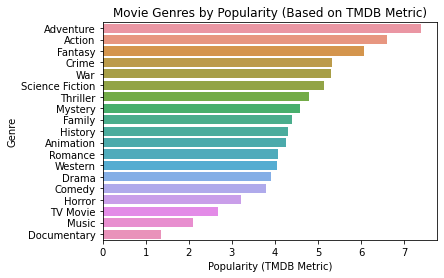

In [33]:
# view top genres
labels = genres_df.index
data = genres_df["popularity"]

f, ax = plt.subplots()
sns.barplot(x=data, y=labels, ax=ax)
plt.title("Movie Genres by Popularity (Based on TMDB Metric)")
plt.xlabel("Popularity (TMDB Metric)")
plt.ylabel("Genre");

# save the image
plt.savefig("./Images/top_popularity.png", bbox_inches='tight')

We can see from the graph that Adventure is the most popular movie genre. We will confirm this assumption with a statistical test.

An interesting note is that we saw that Animation was ranked high in net reveneue but lower in popularity. This may possibly be due to the possibility that many animations are for children who are not old enough to interact with the movies online.

### Test for statistical significance between highest popularity groups <a class="anchor" id="popularity_sig"></a>

In [34]:
# seperate data for comparison
adventures = clean_df[clean_df["genre"]=="Adventure"]
actions = clean_df[clean_df["genre"]=="Action"]

In [35]:
# test for normality
stats.normaltest(actions["popularity"]), stats.normaltest(adventures["popularity"])

(NormaltestResult(statistic=1225.51721098118, pvalue=7.626388000807568e-267),
 NormaltestResult(statistic=567.9831530570949, pvalue=4.613445628736019e-124))

Although the data sets are not perfectly normal, the t-test is robust enough to be applied and we will use this for recommendations.

In [36]:
# compare the two highest popularity groups for statisitcal significance with a t-test using alpha=.05
stats.ttest_ind(adventures["popularity"], actions["popularity"], alternative="greater")

Ttest_indResult(statistic=2.436196970801162, pvalue=0.007450489898373688)

With a p value less than .05 we can reject the null hypothesis and determine that movies with an Adventure genre tag are more popular than those with an Action genre tag.

### Explore TMDB Vote Averages <a class="anchor" id="votes"></a>

In [37]:
# groupby genre vote average, use only data points that included more than 100 votes
# we do not want movies with less than 100 votes to influence the set
genres_df_votes = clean_df[clean_df["vote_count"]>100]
genres_df_votes = genres_df_votes.groupby("genre").mean()[["vote_average"]].sort_values("vote_average", ascending=False)
genres_df_votes

,vote_average
genre,
Documentary,7.383696
Music,6.870130
History,6.833333
War,6.828000
Animation,6.813953
Family,6.594064
Drama,6.576210
Romance,6.521008
Fantasy,6.461250


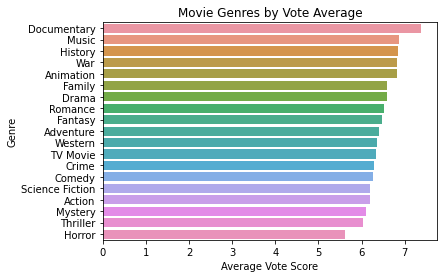

In [38]:
# plot the top genres for highest vote averages
labels = genres_df_votes.index
data = genres_df_votes["vote_average"]

f, ax = plt.subplots()
sns.barplot(x=data, y=labels, ax=ax)
plt.title("Movie Genres by Vote Average")
plt.xlabel("Average Vote Score")
plt.ylabel("Genre");

# save the image
plt.savefig("./Images/top_votes.png", bbox_inches='tight')

We can see that Documentary, Music, and History are the top 3 categories recieiving the best vote averages. They are not near the top on popularity. This may be due to biases where these are specific genres that have a strong following by a tight fanbase that constastly votes them high. This tight fanbase may be the only people voting on these speciailzied genres.

# Recommendation 3: If the goal is to maximize popularity and generate attention, then we recommend producing a movie with the genre tag of Adventure. <a class="anchor" id="rec3"></a>

## Conclusion <a class="anchor" id="conclusion"></a>
The above analysis shows how we arrived at our 3 conclusions:
* If the goal is to maximize gross profit, then we recommend producing a movie with the genre tags of Animation, Adventure, or Sci-Fi.
* If the goal is to maximize net profit, then we recommend producing a movie with the genre tags of Animation.
* If the goal is to maximize popularity and generate attention, then we recommend producing a movie with the genre tag of Adventure.

An interesting note is that we see Animation show up in 2/3 of the recommendations. If a single movie genre had to be chosen, this analysis indicates that Animation would be a strong candidate.